# Self-Driving Car - Behavior Cloning Training for Predicting Steering Angle Using Deep Learning and Data Augmentation

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import shutil
plt.style.use("dark_background")

## Load the Dataset

In [5]:
src = "../input/udacity-self-driving-car-behavioural-cloning/self_driving_car_dataset_make"
dest = "./dataset"
shutil.copytree(src, dest)

'./dataset'

In [8]:
train_df = pd.read_csv("./dataset/driving_log.csv",
                       names=["center_cam", "left_cam", "right_cam", "steering_angle", "throttle", "reverse", "speed"])
train_df = train_df[["center_cam", "left_cam", "right_cam", "steering_angle", "throttle", "reverse", "speed"]] # do not need other values 
train_df.head()

,center_cam,left_cam,right_cam,steering_angle,throttle,reverse,speed
0,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0,0.0,0,0.000013
1,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0,0.0,0,0.000010
2,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0,0.0,0,0.000008
3,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0,0.0,0,0.000021
4,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0,0.0,0,0.000014


In [11]:
train_df = pd.read_csv("./dataset/driving_log.csv",
                       names=["center_cam", "left_cam", "right_cam", "steering_angle", "throttle", "reverse", "speed"])
train_df = train_df[["center_cam", "steering_angle"]] # do not need other values 
train_df.head()

,center_cam,steering_angle
0,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0
1,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0
2,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0
3,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0
4,C:\Users\Andy\Desktop\self_driving_car_dataset...,0.0


In [12]:
train_df["center_cam"][0].split("\\")[-1] #to extract the filename from original path

'center_2022_04_10_12_24_41_840.jpg'

In [13]:
train_df["center_cam"] = train_df["center_cam"].apply(lambda x: x.split("\\")[-1])
train_df.head()

,center_cam,steering_angle
0,center_2022_04_10_12_24_41_840.jpg,0.0
1,center_2022_04_10_12_24_41_908.jpg,0.0
2,center_2022_04_10_12_24_41_976.jpg,0.0
3,center_2022_04_10_12_24_42_044.jpg,0.0
4,center_2022_04_10_12_24_42_116.jpg,0.0


## Data Visualizaiton

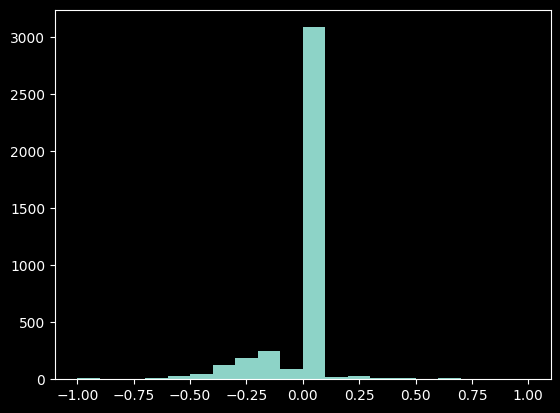

In [14]:
plt.hist(train_df.steering_angle.values, bins=20);

The dataset has a significant imbalance, with the steering class for a value of 0 being heavily over-represented, and a higher frequency of negative values compared to positive. This imbalance can lead to biased model predictions, as the model may become overly focused on the dominant classes. To address this, we could either undersample the over-represented class to reduce its dominance or oversample the under-represented classes to balance the data distribution.

Given the higher count of negative values, this can skew the model's ability to learn patterns effectively across the full steering range. One way to correct this is to collect additional data for positive values. Alternatively, we can apply image augmentation techniques by horizontally flipping the images and inverting the steering angle, which would create synthetic positive data and help balance the model's exposure to different steering directions.

In [15]:
train_df.steering_angle.describe()

count    3930.000000
mean       -0.034529
std         0.133405
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering_angle, dtype: float64

Values that have steering angles that are not 0

In [16]:
non_zero_df = train_df[train_df["steering_angle"] != 0.0]
non_zero_df

,center_cam,steering_angle
6,center_2022_04_10_12_24_42_256.jpg,-0.05
7,center_2022_04_10_12_24_42_324.jpg,-0.20
8,center_2022_04_10_12_24_42_393.jpg,-0.35
9,center_2022_04_10_12_24_42_463.jpg,-0.55
10,center_2022_04_10_12_24_42_531.jpg,-0.70
...,...,...
3863,center_2022_04_10_12_29_10_622.jpg,-0.20
3869,center_2022_04_10_12_29_11_052.jpg,-0.15
3870,center_2022_04_10_12_29_11_126.jpg,-0.35
3895,center_2022_04_10_12_29_12_873.jpg,-0.15


Steering angle inversion data augmentation
We need to create a function that does the following
:
* Take as input image name, location of images, steering angle
* Read image and do a horizontal flip
* Invert steering angle
* Return new image (add flipped) and new angle
 angle

In [17]:
# only use the center cam
img_names = train_df[train_df["steering_angle"] < 0].center_cam.values
img_names[:5]

array(['center_2022_04_10_12_24_42_256.jpg',
       'center_2022_04_10_12_24_42_324.jpg',
       'center_2022_04_10_12_24_42_393.jpg',
       'center_2022_04_10_12_24_42_463.jpg',
       'center_2022_04_10_12_24_42_531.jpg'], dtype=object)

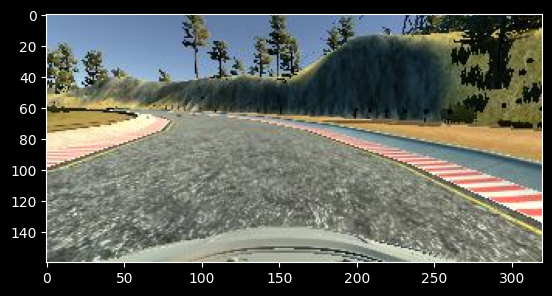

In [18]:
img_dir = "./dataset/IMG"
img_path = os.path.join(img_dir, img_names[0])
img = plt.imread(img_path)
plt.imshow(img);

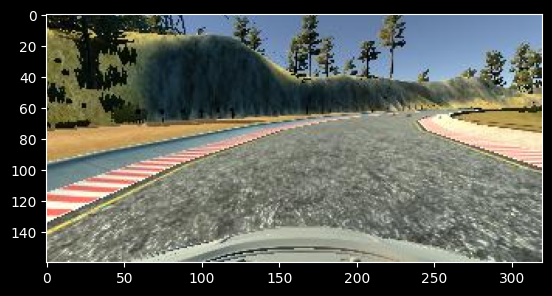

In [19]:
plt.imshow(cv2.flip(img, 1))

In [21]:
def augment_data(img_dir, img_name, label):
    img_path = os.path.join(img_dir, img_name)
    img = plt.imread(img_path)
    return (cv2.flip(img, 1), (-label))

0.5


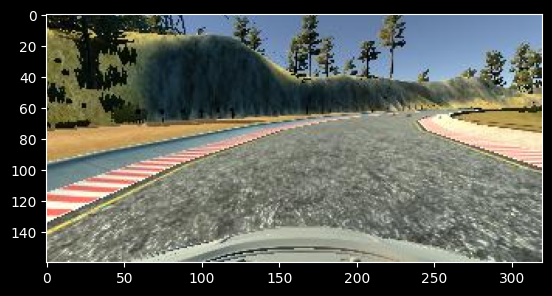

In [22]:
flipped_img, new_label = augment_data(img_dir, img_names[0], -0.5)
plt.imshow(flipped_img);
print(new_label)  #the testing work well!

In [24]:
def augment_and_save(img_dir, img_name, label):
    img_path = os.path.join(img_dir, img_name)
    img = plt.imread(img_path)
    new_img_name = img_name.replace(".jpg", "") + "_flipped.jpg"
    new_img_path = os.path.join(img_dir, new_img_name)
    cv2.imwrite(new_img_path, cv2.flip(img, 1))
    return (new_img_name, (-label))

In [28]:
images = []
labels = []

img_dir = "./dataset/IMG"

for index, data in non_zero_df.iterrows():#apply it to non zero!
    image, label = augment_and_save(img_dir, data["center_cam"],  data["steering_angle"])
    images.append(image)
    labels.append(label)

0.05


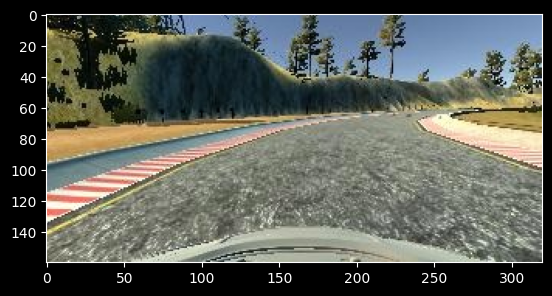

In [29]:
img_path = os.path.join(img_dir, images[0])
img = plt.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
print(labels[0])

In [32]:
augmented_df = pd.DataFrame(list(zip(images, labels)), columns=["center_cam", "steering_angle"])

In [33]:
zero_df = train_df.query("steering_angle == 0.0").sample(frac=.05)   #Dropping random zero values
#We will only take 5% of the original dataset of steering angle of 0
len(zero_df)   

153

In [34]:
new_train_df = pd.concat([zero_df, augmented_df, non_zero_df])
new_train_df.head()

,center_cam,steering_angle
465,center_2022_04_10_12_25_14_400.jpg,0.0
76,center_2022_04_10_12_24_47_157.jpg,0.0
460,center_2022_04_10_12_25_14_057.jpg,0.0
462,center_2022_04_10_12_25_14_191.jpg,0.0
3632,center_2022_04_10_12_28_54_514.jpg,0.0


In [35]:
len(new_train_df)

1891

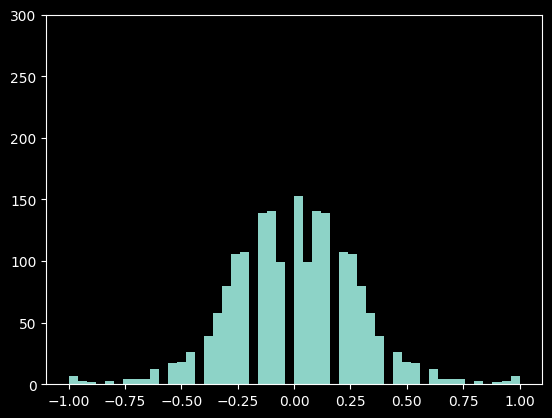

In [36]:
plt.ylim(0, 300)
plt.hist(new_train_df.steering_angle.values, bins=50);

## Preparing Data for Model

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Now you can use ImageDataGenerator as before
datagen = ImageDataGenerator(validation_split=0.2)

In [39]:
train_generator=datagen.flow_from_dataframe(
  dataframe=new_train_df,
  directory="./dataset/IMG",
  x_col="center_cam",
  y_col="steering_angle",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(160, 320),
)

valid_generator=datagen.flow_from_dataframe(
  dataframe=new_train_df,
  directory="./dataset/IMG",
  x_col="center_cam",
  y_col="steering_angle",
  subset="validation",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(160, 320),
)

Found 1513 validated image filenames.
Found 378 validated image filenames.


## Create Model and train
The model will be created with a simple VGG like network.

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.RandomContrast(0.5),
    ]
)

In [42]:
model = tf.keras.Sequential([
    layers.Input(shape=(160, 320, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [43]:
model.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(),
)

model.fit(train_generator, epochs=15,
          validation_data=valid_generator)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 2.4533 - val_loss: 0.1517
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 0.1866 - val_loss: 0.1914
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 0.1643 - val_loss: 0.1384
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.1367 - val_loss: 0.1367
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - loss: 0.1200 - val_loss: 0.1499
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 0.1148 - val_loss: 0.1247
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 0.1136 - val_loss: 0.0964
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 0.1098 - val_loss: 0.1184
Epoch 9/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - loss: 0.0993 - val_loss: 0.1658
Epoch 10/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 0.0974 - val_loss: 0.1479
Epoch 11/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0969 - val_loss: 0.1336
Epoch 12/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 0.0930 - val_loss: 0.1411


In [44]:
img.shape

(160, 320, 3)

In [45]:
np.squeeze(model.predict(tf.expand_dims(img, axis=0)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


array(0.2360956, dtype=float32)

In [50]:
model.save("./self_driving_model.h5")

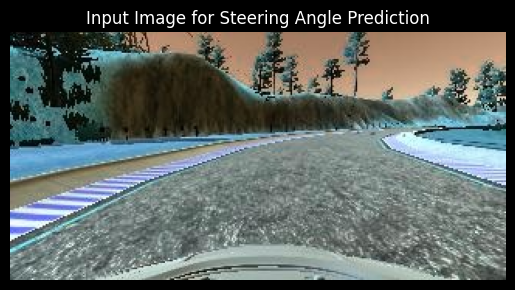

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Steering Angle: 0.2360956


In [47]:
# Display the image
plt.imshow(img)
plt.title("Input Image for Steering Angle Prediction")
plt.axis('off')
plt.show()

# Make prediction and format output
predicted_steering_angle = np.squeeze(model.predict(tf.expand_dims(img, axis=0)))
print("Predicted Steering Angle:", predicted_steering_angle)